<a href="https://colab.research.google.com/github/elan-wilkinson/OrientationDetectionLegoAerospaceAssembly/blob/main/Main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Exploration of Orientation Detection of LEGO Shuttle Assembly
Contributors: Elan Wilkinson, Ahmad Milad, Pallav Kamojjhala

Understanding the orientation of parts of an assembly or larger structure is of pivotal importance for their correct installation and quality inspection of that installation. The task of human or robotic assembly and detecting improper rotation or assemblage is shared problem in a broad variety of domains from aerospace, automobile manufacturing, industrial production engineering, medical device assemblage, and amny others.

This project seeks to determine feasibility and accuracy of rotation detection of a three dimensional object using computer vision without depth information, using models which are capable of running in real time and using simpler architectures WITH transfer learning. The selected models use learned features rather than requiring human determined features for better scalability, and for extensibility for training additional models on other parts or changing parts over time.

# LEGO Shuttle Orientation Detction Using Residual Neural Network (ResNet)


### Import Necessary Libraries

In [ ]:
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import os
import zipfile

### Connection to Drive Storage

In [1]:
# Connect to Drive Storage
from google.colab import drive
drive.mount('/content/drive')

MessageError: Error: credential propagation was unsuccessful

## Import of Synthetic Data and Annotation Files

Multiple sets of synthetic data were generated. Prior to establishing the focus on the shuttle assembly, data generation and orientation detection were explored on vehicles, puzzle parts, and a dinosaur toy. Testing only on synthetic data with the dinosaur toy, results were extremely accurage, typically within less than five degrees, which encouraged pursuit of this particular architecture.

Not shown here, a YOLO and basic CNN approach were develped, with signicantly poorer results, so these were trimmed and discarded.

Ultimately, three main sets of synthetic data were generated for end usage, each consisting of 20,000 images; one of the largest shuttle piece, at varying distances and off center, one of a secondary piece, at varying distances and off center, and one of the largest shuttle piece, in center and relatively close, simulating use either on close objects, or on images that have been cropped depending on their detected bounding box with some padding to avoid clipping.

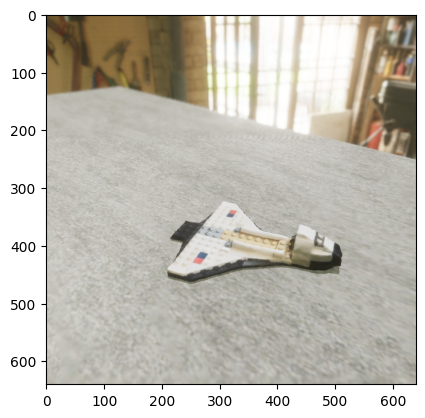

In [ ]:
# display image at sequence.0/step0.camera.png
img = Image.open(os.path.join(shuttle_images_dir, "sequence.11/step0.camera.png"))
plt.imshow(img)

# Synthetic Image Generation
In most modern industrial contexts, Computer-Aided Design (CAD) models would be available for synthetic data generation. Older engineering data typically lacks this would require either creation of these models or capture of the structure via scans.

In a similar manner to the latter context, the chosen testing item lacked CAD and it was necessary to generate a 3D representation for syntehtic image generation.

Minimal scan cleanup was performed in [Blender](https://www.blender.org/) to remove the surface below the scanned object, to again simulate minimal human effort in the pipeline of scan to data generation to model training.

This was performed using the tool [Scaniverse](https://scaniverse.com/), which uses Gaussian splatting to generate rich volumetric point clouds which can be automatically converted to 3-Dimension textured models. The device hardware used for this capture with Scaniverse was an iPhone 13 mini.

This 3D model was then imported into [Unity 6](https://unity.com/releases/unity-6) which was then used to generate the synthetic images using the [Perception](https://docs.unity3d.com/Packages/com.unity.perception@1.0/manual/index.html) package.

In addition to using the 3D scanned model, High Dynamic Range Images (HDRI) backgrounds from [Poly Haven](https://polyhaven.com/hdris) were used as well as various free table models from [Turbosquid](https://www.turbosquid.com/) on which the scanned models were placed.


**Features randomized during synthetic data generation include:**
- camera angle relative to the model
- camera position relative to the model
- camera distance from the model
- the background image used
- the rotation of the background image
- the angle of the light
- the temperature of the light
- the brightness of the light
- the table or surface the model was resting on

The project was set up so that the part in question being captured could easily be swapped out at will for other parts.

Unity is generally capable of running in a scripted headless manner, so in future iterations, this could be incorporated into a pipeline.

Annotations generated during training included Euler rotation, Quaternion rotation, 2-Dimensional screen bounding boxes, and 3-Dimensional bounding boxes.

In [3]:
shuttle_euler_text_file = '/content/drive/MyDrive/CV_FinalProj_Data/close_dist/shuttle_main_closeDist/0.txt'
shuttle_euler_rots_df = pd.read_csv(shuttle_euler_text_file, sep=",", header=None)

In [4]:
shuttle_euler_rots_df = shuttle_euler_rots_df.rename(columns={0: 'x'})
shuttle_euler_rots_df = shuttle_euler_rots_df.rename(columns={1: 'y'})
shuttle_euler_rots_df = shuttle_euler_rots_df.rename(columns={2: 'z'})

In [5]:
shuttle_euler_rots_df = (shuttle_euler_rots_df - 180.0)/180.0

In [6]:
shuttle_euler_rots_df['img name'] = ""
# create annotations file:
for i in range(0,20000):
  shuttle_euler_rots_df.loc[i, 'img name'] = "sequence." + str(i) + "/" + "step0.camera.png"

In [7]:
shuttle_euler_rots_df = shuttle_euler_rots_df.reindex(columns=['img name', 'x', 'y', 'z'])

In [9]:
shuttle_euler_rots_df.tail(5)

,img name,x,y,z
19996,sequence.19996/step0.camera.png,-0.711986,-0.290344,-1.0
19997,sequence.19997/step0.camera.png,-0.652041,0.259622,-1.0
19998,sequence.19998/step0.camera.png,-0.803894,-0.423482,-1.0
19999,sequence.19999/step0.camera.png,-0.854223,0.974591,-1.0
20000,sequence.20000/step0.camera.png,-0.737619,0.796913,-1.0


In [8]:
shuttle_euler_rots_df.loc[20000, 'img name'] = "sequence.20000/step0.camera.png"

### Example Image from Synthetic Dataset

In [16]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import pandas as pd
import os
from sklearn.model_selection import train_test_split
import torch.nn.functional as F

# Define the custom model
class ResNetRotationModel(nn.Module):
    def __init__(self, pretrained=True):
        super(ResNetRotationModel, self).__init__()
        # Load a pre-trained ResNet model
        self.backbone = models.resnet18(pretrained=pretrained)
        num_features = self.backbone.fc.in_features
        # Replace the fully connected layer with a custom head for regression
        self.backbone.fc = nn.Linear(num_features, 3)  # Output x, y, z rotations

    def forward(self, x):
        return self.backbone(x)

# Define a custom dataset
class RotationDataset(Dataset):
    def __init__(self, image_dir, annotations, transform=None):
        self.image_dir = image_dir
        self.annotations = annotations
        self.transform = transform

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, idx):
        if isinstance(idx, torch.Tensor):
            idx = idx.item()

        # Load image
        img_name = os.path.join(self.image_dir, str(self.annotations.iloc[idx, 0]))
        image = Image.open(img_name).convert("RGB")

        # Load rotation labels (x, y, z)
        rotation_labels = self.annotations.iloc[idx, 1:4].values.astype('float')
        rotation_labels = torch.tensor(rotation_labels, dtype=torch.float32)

        if self.transform:
            image = self.transform(image)

        return image, rotation_labels

# Paths
images = '/content/drive/MyDrive/CV_FinalProj_Data/close_dist/shuttle_main_closeDist/solo/'
annotations_file = shuttle_euler_rots_df

# Define transformations for images
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to match ResNet input size
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Standard normalization for ResNet
])

# Split data
train_annotations, test_annotations = train_test_split(annotations_file, test_size=0.2, random_state=42)


train_dataset = RotationDataset(image_dir=images, annotations=train_annotations, transform=transform)
test_dataset = RotationDataset(image_dir=images, annotations=test_annotations, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)

# Model, loss, and optimizer
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model = ResNetRotationModel(pretrained=True).to(device)



criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)



# Training loop
num_epochs = 7
for epoch in range(num_epochs):
    model.train()
    for images, rotation_labels in train_loader:
        images, rotation_labels = images.to(device), rotation_labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, rotation_labels)
        loss.backward()
        optimizer.step()

    # Evaluation
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for test_images, test_rotation_labels in test_loader:
            test_images, test_rotation_labels = test_images.to(device), test_rotation_labels.to(device)
            test_outputs = model(test_images)
            test_loss += criterion(test_outputs, test_rotation_labels).item()

    print(f"Epoch {epoch + 1}, Loss: {loss.item()}, Test Loss: {test_loss / len(test_loader)}")

Epoch 1, Loss: 0.0035539446398615837, Test Loss: 0.008887572286997937
Epoch 2, Loss: 0.003181790467351675, Test Loss: 0.00431739019982088
Epoch 3, Loss: 0.004285516683012247, Test Loss: 0.007687833756097548
Epoch 4, Loss: 0.0007871666457504034, Test Loss: 0.0020286039389103526
Epoch 5, Loss: 0.0003778823302127421, Test Loss: 0.0022934313869521408
Epoch 6, Loss: 0.00018747092690318823, Test Loss: 0.0017354340046054743
Epoch 7, Loss: 0.0007155972416512668, Test Loss: 0.002661787188290397


In [17]:
# prompt: save the model weights

# Save the trained model's state dictionary
torch.save(model.state_dict(), '/content/drive/MyDrive/USD/rotation_closer_resnet_model.pth')

In [18]:
predictions = []
model.eval()
with torch.no_grad():
    for test_images, test_rotation_labels in test_loader:
        test_images = test_images.to(device)
        test_outputs = model(test_images)
        predictions.extend(test_outputs.cpu().numpy())

In [19]:
import numpy as np
predictions_array = np.array(predictions)
orig = []

for val in test_annotations.iloc[:, 1:4].values:
  orig.append(val)

orig_array = np.array(orig)

predictions_degrees = predictions_array * 180.0
orig_degrees = orig_array * 180.0

differences = orig_degrees - predictions_degrees
differences = np.abs(differences)

differences_df = pd.DataFrame(differences, columns=['x', 'y', 'z'])

x_avg = differences_df['x'].mean()
y_avg = differences_df['y'].mean()
z_avg = differences_df['z'].mean()

print(f"Average difference in x: {x_avg}")
print(f"Average difference in y: {y_avg}")
print(f"Average difference in z: {z_avg}")

differences_df.head(10)




Average difference in x: 2.760794118410705
Average difference in y: 5.993273260956971
Average difference in z: 1.7534514445668368


,x,y,z
0,1.865738,6.730798,4.652481
1,2.446438,7.724503,2.065948
2,3.196534,0.548869,2.474045
3,1.555662,1.826883,0.031326
4,1.009450,7.484437,2.844788
5,0.899486,1.838891,4.359573
6,0.293295,4.814823,1.943695
7,6.109125,2.295962,4.314133
8,4.980198,17.045195,5.376373
9,5.456059,17.745663,3.732147


# test the resnet 18 on closer images on real world data

In [20]:
import zipfile
import os

from google.colab import drive
drive.mount('/content/drive')

zip_file_path = '/content/drive/MyDrive/CV_FinalProj_Data/shuttle_rw_45degs.zip'
extract_dir = '/content/drive/MyDrive/CV_FinalProj_Data/shuttle_realworld_45degs'

# Create the extract directory if it doesn't exist
os.makedirs(extract_dir, exist_ok=True)

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [28]:
real_rots = pd.read_csv('/content/drive/MyDrive/CV_FinalProj_Data/shuttle_realworld_45degs/shuttle_rw_45degs/angles.csv', sep=",")

real_rots['X'] = (real_rots['X'] - 180.0) / 180.0
real_rots['Y'] = (real_rots['Y'] - 180.0)/ 180.0
real_rots['Z'] = (real_rots['Z'] - 180.0)/ 180.0

real_rots.tail(5)

,Image File,X,Y,Z
221,IMG_4662.png,-0.75,0.5,-1.0
222,IMG_4670.png,-0.75,0.5,-1.0
223,IMG_4677.png,-0.75,0.5,-1.0
224,IMG_4685.png,-0.75,0.5,-1.0
225,IMG_4693.png,-0.75,0.5,-1.0


In [29]:
# Path to the new test images and their labels
new_test_images = '/content/drive/MyDrive/CV_FinalProj_Data/shuttle_realworld_45degs/shuttle_rw_45degs/images/'
new_test_annotations_file = real_rots  # DataFrame containing labels for the new test images

# Reuse the same transform pipeline
new_transform = transform  # Already defined

# Create a new dataset and dataloader for the new test images
new_test_dataset = RotationDataset(image_dir=new_test_images, annotations=new_test_annotations_file, transform=new_transform)
new_test_loader = DataLoader(new_test_dataset, batch_size=32, shuffle=False, num_workers=4)

predictions = []
model.eval()
with torch.no_grad():
    for test_images, test_rotation_labels in new_test_loader:
        test_images = test_images.to(device)
        test_outputs = model(test_images)
        predictions.extend(test_outputs.cpu().numpy())


In [53]:
predictions_array = np.array(predictions)
orig = []

for val in new_test_annotations_file.iloc[:, 1:4].values:
  orig.append(val)

orig_array = np.array(orig)

predictions_degrees = predictions_array * 180.0
orig_degrees = orig_array * 180.0

differences = []

a = -100
b = 175

c = 85

def Get_Difference(a, b):
  differences = []
  for i in range (0, len(a)):
    diff_a = 180
    if (a[i] < 0) and (b[i] > 0):
      diff_a = abs((a[i] + 180) - (b[i]+180))
    elif (a[i] > 0 and b[i] < 0):
      diff_a = abs((a[i] - 180) - (b[i] - 180))
    diff_b = abs(a[i] - b[i])
    differences.append(min(diff_a, diff_b))
  return differences


x_diff = Get_Difference(orig_array[:, 0]*180, predictions_array[:,0]*180)
y_diff = Get_Difference(orig_array[:, 1]*180, predictions_array[:,1]*180)
z_diff = Get_Difference(orig_array[:, 2]*180, predictions_array[:,2]*180)

differences = np.array([x_diff, y_diff, z_diff])
differences = differences.T


differences_df = pd.DataFrame(differences, columns=['X', 'Y', 'Z'])

x_avg = np.mean(x_diff)
y_avg = np.mean(y_diff)
z_avg = np.mean(z_diff)


print(f"Average difference in x: {x_avg}")
print(f"Average difference in y: {y_avg}")
print(f"Average difference in z: {z_avg}")

x_mean = np.median(x_diff)
y_mean = np.median(y_diff)
z_mean = np.median(z_diff)

print(f"Mean difference in x: {x_mean}")
print(f"Mean difference in y: {y_mean}")
print(f"Mean difference in z: {z_mean}")

differences_df.head(10)
print(x_diff)

Average difference in x: 12.054029954218231
Average difference in y: 32.23366303280392
Average difference in z: 3.3058475730693444
Mean difference in x: 11.380596160888672
Mean difference in y: 11.200945854187012
Mean difference in z: 2.58428955078125
[7.365303039550781, 0.179107666015625, 15.182411193847656, 21.783355712890625, 23.695266723632812, 13.366218566894531, 0.7610321044921875, 6.128662109375, 8.597007751464844, 0.5527191162109375, 16.570709228515625, 12.380928039550781, 9.837882995605469, 15.051437377929688, 16.917808532714844, 3.62530517578125, 12.000480651855469, 1.1167831420898438, 5.218345642089844, 14.082870483398438, 2.1899261474609375, 9.640640258789062, 18.081443786621094, 5.113868713378906, 7.3324432373046875, 14.203147888183594, 11.799713134765625, 14.022193908691406, 6.596466064453125, 3.2951889038085938, 10.252037048339844, 20.61310577392578, 6.878120422363281, 10.820274353027344, 11.011421203613281, 5.709617614746094, 4.037193298339844, 3.3646926879882812, 0.013

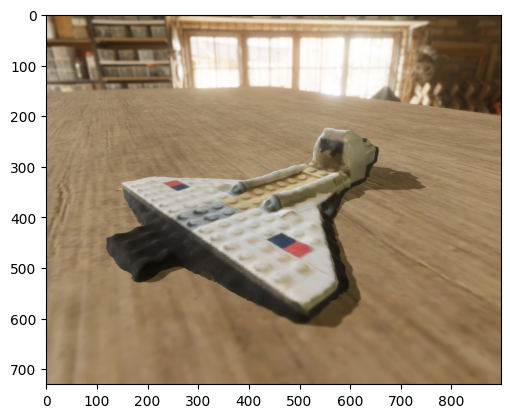

In [ ]:
# display image at sequence.0/step0.camera.png
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import os

shuttle_images_dir = '/content/drive/MyDrive/CV_FinalProj_Data/close_dist/shuttle_main_closeDist/solo/'
img = Image.open(os.path.join(shuttle_images_dir, "sequence.11/step0.camera.png"))
plt.imshow(img)

# Cropped Edition



In [ ]:
import os
import math

In [ ]:
images_dir = '/content/drive/MyDrive/CV_FinalProj_Data/Shuttle_main_cropped/images'
labels_dir = '/content/drive/MyDrive/CV_FinalProj_Data/shuttle_main/shuttle_main_rotations.txt'

In [ ]:
labels_df = pd.read_csv(labels_dir, header=None)
labels_df['image name'] = ""
for idx, fow in enumerate(os.listdir(images_dir)):
  labels_df.loc[idx, 'image name'] = 'sequence.' + str(idx) + '.png'
# rename the first 3 columns to x,y, and z
labels_df = labels_df.rename(columns={0: 'x'})
labels_df = labels_df.rename(columns={1: 'y'})
labels_df = labels_df.rename(columns={2: 'z'})
labels_df = labels_df.reindex(columns=['image name', 'x', 'y', 'z'])
# normalize the x and y columns by subtracting 180 and then dividing by 180


In [ ]:
labels_df[['x', 'y', 'z']] = (labels_df[['x', 'y', 'z']] - 180.0) / 180.0

In [ ]:
labels_df.head(5)

,image name,x,y,z
0,sequence.0.png,-0.717339,-0.115415,-1.0
1,sequence.1.png,-0.938051,-0.552221,-1.0
2,sequence.2.png,-0.695901,-0.770674,-1.0
3,sequence.3.png,-0.751306,-0.265214,-1.0
4,sequence.4.png,-0.723213,-0.170456,-1.0


In [ ]:
# multiply by 180 and add 180
labels_df_old = labels_df.copy()
labels_df_old[['x', 'y', 'z']] = labels_df[['x', 'y', 'z']] * 180.0 + 180.0
labels_df_old.head(5)

,image name,x,y,z
0,sequence.0.png,50.8789,159.2253,0.0
1,sequence.1.png,11.1509,80.6002,0.0
2,sequence.2.png,54.7378,41.2786,0.0
3,sequence.3.png,44.7649,132.2614,0.0
4,sequence.4.png,49.8217,149.3180,0.0


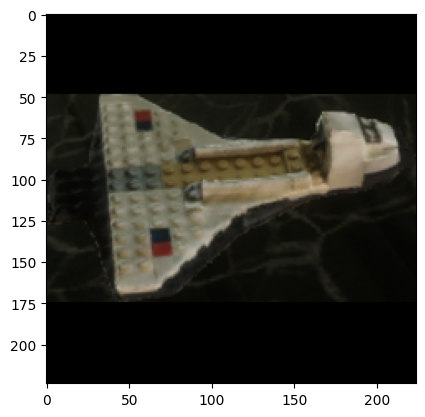

In [ ]:
from torchvision import transforms
from PIL import Image, ImageOps
import matplotlib.pyplot as plt
image_path = "/content/drive/MyDrive/CV_FinalProj_Data/Shuttle_main_cropped/images/sequence.6.png"

# resize to transforms.Resize((224, 224)),
img = Image.open(image_path).convert("RGB")
img = resize_with_padding(img, target_size=(224, 224), fill=(0, 0, 0))
plt.imshow(img)

In [ ]:
print(images_dir)

/content/drive/MyDrive/CV_FinalProj_Data/Shuttle_main_cropped/images


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import pandas as pd
import os
from sklearn.model_selection import train_test_split
import torch.nn.functional as F



# Define the custom model
class ResNetRotationModel(nn.Module):
    def __init__(self, pretrained=True):
        super(ResNetRotationModel, self).__init__()
        # Load a pre-trained ResNet model
        self.backbone = models.resnet50(pretrained=pretrained)
        num_features = self.backbone.fc.in_features
        # Replace the fully connected layer with a custom head for regression
        self.backbone.fc = nn.Linear(num_features, 3)  # Output x, y, z rotations

    def forward(self, x):
        return self.backbone(x)

# Define a custom dataset
class RotationDataset(Dataset):
    def __init__(self, image_dir, annotations, transform=None):
        self.image_dir = image_dir
        self.annotations = annotations
        self.transform = transform

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, idx):
        if isinstance(idx, torch.Tensor):
            idx = idx.item()

        # Load image
        img_name = os.path.join(self.image_dir, str(self.annotations.iloc[idx, 0]))
        image = Image.open(img_name).convert("RGB")

        # Load rotation labels (x, y, z)
        rotation_labels = self.annotations.iloc[idx, 1:4].values.astype('float')
        rotation_labels = torch.tensor(rotation_labels, dtype=torch.float32)

        if self.transform:
            image = self.transform(image)

        return image, rotation_labels

# Paths
images = images_dir
annotations_file = labels_df

def resize_with_padding(img, target_size=(224, 224), fill=(0, 0, 0)):
    original_width, original_height = img.size
    target_width, target_height = target_size
    aspect_ratio = original_width / original_height

    # Calculate new dimensions
    if aspect_ratio > 1:  # Wider than tall
        new_width = target_width
        new_height = int(target_width / aspect_ratio)
    else:  # Taller than wide
        new_height = target_height
        new_width = int(target_height * aspect_ratio)

    # Resize the image
    resized_img = img.resize((new_width, new_height))

    # Add padding to center the image
    padded_img = ImageOps.expand(
        resized_img,
        border=(
            (target_width - new_width) // 2,
            (target_height - new_height) // 2,
            (target_width - new_width + 1) // 2,
            (target_height - new_height + 1) // 2,
        ),
        fill=fill,
    )
    return padded_img

# Define the transforms.Compose pipeline
transform = transforms.Compose([
    transforms.Lambda(lambda img: resize_with_padding(img, target_size=(224, 224), fill=(0, 0, 0))),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Standard normalization for ResNet
])



# Split data
train_annotations, test_annotations = train_test_split(annotations_file, test_size=0.2, random_state=42)


train_dataset = RotationDataset(image_dir=images, annotations=train_annotations, transform=transform)
test_dataset = RotationDataset(image_dir=images, annotations=test_annotations, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)

# Model, loss, and optimizer
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model = ResNetRotationModel(pretrained=True).to(device)



criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)



# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    for images, rotation_labels in train_loader:
        images, rotation_labels = images.to(device), rotation_labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, rotation_labels)
        loss.backward()
        optimizer.step()

    # Evaluation
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for test_images, test_rotation_labels in test_loader:
            test_images, test_rotation_labels = test_images.to(device), test_rotation_labels.to(device)
            test_outputs = model(test_images)
            test_loss += criterion(test_outputs, test_rotation_labels).item()

    print(f"Epoch {epoch + 1}, Loss: {loss.item()}, Test Loss: {test_loss / len(test_loader)}")

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1, Loss: 0.08749908208847046, Test Loss: 0.12246440824062105
Epoch 2, Loss: 0.1432625651359558, Test Loss: 0.12034300708818058
Epoch 3, Loss: 0.11856242269277573, Test Loss: 0.12050046416975203
Epoch 4, Loss: 0.11369520425796509, Test Loss: 0.12507592194846698
Epoch 5, Loss: 0.11713434755802155, Test Loss: 0.1379903027462581
Epoch 6, Loss: 0.09095199406147003, Test Loss: 0.1512274785292527
Epoch 7, Loss: 0.051060765981674194, Test Loss: 0.16124791515961526
Epoch 8, Loss: 0.0254680123180151, Test Loss: 0.15302635534178644
Epoch 9, Loss: 0.017315536737442017, Test Loss: 0.1515230436528486
Epoch 10, Loss: 0.031265828758478165, Test Loss: 0.14800380619745407


In [ ]:
# prompt: # get predictions and compare to original, then multiply both by 180 and get average difference

predictions = []
model.eval()
with torch.no_grad():
    for test_images, test_rotation_labels in test_loader:
        test_images = test_images.to(device)
        test_outputs = model(test_images)
        predictions.extend(test_outputs.cpu().numpy())
predictions_array = np.array(predictions)
orig = []

for val in test_annotations.iloc[:, 1:4].values:
  orig.append(val)

orig_array = np.array(orig)

predictions_degrees = predictions_array * 180.0
orig_degrees = orig_array * 180.0

differences = orig_degrees - predictions_degrees
differences = np.abs(differences)

differences_df = pd.DataFrame(differences, columns=['x', 'y', 'z'])

x_avg = differences_df['x'].mean()
y_avg = differences_df['y'].mean()
z_avg = differences_df['z'].mean()

print(f"Average difference in x: {x_avg}")
print(f"Average difference in y: {y_avg}")
print(f"Average difference in z: {z_avg}")

differences_df.head(10)

Average difference in x: 25.638549886737913
Average difference in y: 96.96026098789615
Average difference in z: 1.3987358992344199


,x,y,z
0,20.547286,120.010142,4.417999
1,10.865977,4.980507,2.590668
2,3.833603,155.534386,1.545380
3,29.075725,36.584063,1.103897
4,27.883676,11.522525,2.342133
5,29.956245,148.099441,0.033920
6,4.944537,117.893517,1.109634
7,14.045554,156.824156,0.650192
8,47.167326,182.751873,2.366913
9,39.780833,143.265802,0.956284


In [ ]:
torch.save(model.state_dict(), '/content/drive/MyDrive/USD/rotation_resnet_model.pth')

In [ ]:
import zipfile
import os

from google.colab import drive
drive.mount('/content/drive')

zip_file_path = '/content/drive/MyDrive/CV_FinalProj_Data/shuttle_realworld_data.zip'
extract_dir = '/content/drive/MyDrive/CV_FinalProj_Data/shuttle_realworld_data'

# Create the extract directory if it doesn't exist
os.makedirs(extract_dir, exist_ok=True)

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
real_rots = []

for idx in range(0,298):
  rot_file = os.path.join(extract_dir,'shuttle_realworld_data','rot_' + str(idx) + '.txt')
  with open(rot_file, 'r') as f:
    rot_text = f.read()
    rot_vals = rot_text.split('\n')[0]
    rot_vals = rot_vals.split(',')
    rot_vals = [float(val) for val in rot_vals]
    real_rots.append(rot_vals)


In [ ]:
real_data = pd.DataFrame(real_rots, columns=['x', 'y', 'z'])
real_data.head(5)

,x,y,z
0,289.7448,359.6056,187.5341
1,289.7448,359.6056,187.5341
2,291.5407,183.4960,1.3609
3,291.5407,183.4960,1.3609
4,291.5407,183.4960,1.3609


In [ ]:
real_data['image name'] = ""
for idx in range(0,298):
  real_data.loc[idx, 'image name'] = 'SavedTexture' + str(idx) + '.png'

In [ ]:
real_data = real_data.reindex(columns=['image name', 'x', 'y', 'z'])
real_data.head(5)

normalized_real_data = real_data.copy()
normalized_real_data[['x', 'y', 'z']] = (normalized_real_data[['x', 'y', 'z']] - 180.0) / 180.0
normalized_real_data.head(5)

,image name,x,y,z
0,SavedTexture0.png,0.609693,0.997809,0.041856
1,SavedTexture1.png,0.609693,0.997809,0.041856
2,SavedTexture2.png,0.619671,0.019422,-0.992439
3,SavedTexture3.png,0.619671,0.019422,-0.992439
4,SavedTexture4.png,0.619671,0.019422,-0.992439


In [ ]:
normalized_real_data.head()

,image name,x,y,z
0,SavedTexture0.png,0.609693,0.997809,0.041856
1,SavedTexture1.png,0.609693,0.997809,0.041856
2,SavedTexture2.png,0.619671,0.019422,-0.992439
3,SavedTexture3.png,0.619671,0.019422,-0.992439
4,SavedTexture4.png,0.619671,0.019422,-0.992439
